# Simulating multiqubit spectra

In [1]:
import numpy as np
from qsweepy import *
from qsweepy.fitters import *
from qsweepy.fitters.multiqubit_spectra import *
from qsweepy.ponyfiles import *
import qutip

Failed loading module Keysight_M3102A:  No module named 'keysightSD1'
Failed loading module Keysight_M3202A:  No module named 'keysightSD1'
[WinError 126] The specified module could not be found
Failed loading module Signal_Hound_SA:  name 'signal_hound_dll' is not defined


In [2]:
sample_name = '11qubits_021119'
db = database.MyDatabase()

sweeper = sweep_extras.Sweeper(db, sample_name=sample_name)
exdir_db_inst = exdir_db.Exdir_db(db=db, sample_name=sample_name)

params = load_parameters_dict(exdir_db_inst)

In [3]:
num_qubits = 11
num_levels_per_qubit = 3
f1 = 3.75
EC = params['EC']/1e9
H01 = np.asarray([[0,0,0],[0,f1,0],[0,0,2*f1-EC,]])
H01 = qutip.Qobj(H01)
H01

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.    0.    0.   ]
 [0.    3.75  0.   ]
 [0.    0.    7.345]]

In [4]:
#params['J1']
J1 = 0.0140
J2 = 0.0045

In [5]:
params['J2']

0.0038131487981033206

In [6]:
def simulate_non_driven_frequencies(num_qubits, qubit_frequencies, J1, J2, threshold=0.02, threshold_qubit_id=0):
    # diagonal
    H0i = []
    for qubit_id in range(num_qubits):
        Hi = []
        for qubit_id2  in range(num_qubits):
            if qubit_id == qubit_id2:
                H01 = qutip.Qobj(np.diag([0, qubit_frequencies[qubit_id], qubit_frequencies[qubit_id]*2-params['EC']]))
                Hi.append(H01)
            else:
                Hi.append(qutip.qeye(num_levels_per_qubit))
        H0i.append(qutip.tensor(*Hi))
    H0 = sum(H0i)
    #interaction
    Hii = []
    for qubit_id in range(num_qubits):
        Hi = []
        for qubit_id2  in range(num_qubits):
            ai = qutip.destroy(3)
            if qubit_id == qubit_id2:
                if qubit_id % 2:
                    J = J2
                else:
                    J = J1
                Hi.append((ai+ai.dag())*J*np.sqrt(qubit_frequencies[qubit_id]))
            elif qubit_id + 1 == qubit_id2:
                Hi.append((ai+ai.dag())*np.sqrt(qubit_frequencies[qubit_id+1]))
            else:
                Hi.append(qutip.qeye(num_levels_per_qubit))
        Hii.append(qutip.tensor(*Hi))
    Hint = sum(Hii)
    
    threshold_operator = []
    for qubit_id in range(num_qubits):
        if qubit_id == threshold_qubit_id:
            threshold_operator.append(qutip.Qobj([[0,0,0],[0,1,0],[0,0,2]]))
        else:
            threshold_operator.append(qutip.qeye(3))
    threshold_operator = qutip.tensor(*threshold_operator)
    
    Hnd = Hint+H0
    sparse = num_qubits != 1
    vals, vecs = Hnd.eigenstates(sparse=sparse, sort='low', eigvals=num_qubits*(num_qubits+3)//2+1)
    vals_visible = []
    vecs_visible = []
    for val, vec in zip(vals, vecs):
        #if qutip.expect(threshold_operator, vec) > threshold:
        vals_visible.append(val)
        vecs_visible.append(vec)
    
    return vals_visible, vecs_visible

In [7]:
from matplotlib import pyplot as plt
import traceback
%matplotlib inline

In [8]:
#coil_qubits = {'1':20, '2':18, '3':16, '4':13, '5':12, '6':10, '7':8, '8':6, '9':4, '10':2, '11':0}
from collections import OrderedDict
coil_qubits = OrderedDict({20:'1', 18:'2', 16:'3', 13:'4', 12:'5', 10:'6', 8:'7', 6:'8', 4:'9', 2:'10', 0:'11'})
params['qubits'] = params['EJ1'].keys()
inductance_matrix = build_inductance_matrix(params)

In [9]:
params

{'inductance_matrix_type': 'chain-nn',
 'qubit_resonator_individual': 'equal_claws',
 'qubit_qubit_coupling': 'alternating-chain-nn',
 'EC': 155000000.0,
 'g': 637.491792986728,
 'J1': 0.013269317721392351,
 'J2': 0.0038131487981033206,
 'EJ1': {'1': 12307311816.10025,
  '2': 11575279216.518478,
  '3': 12087831752.372967,
  '4': 11670161593.326704,
  '5': 11437568285.911942,
  '6': 11260652821.585165,
  '7': 12217541337.228148,
  '8': 11503246180.41603,
  '9': 12025793913.146032,
  '10': 11443851304.055477,
  '11': 11772234027.64169},
 'EJ2': {'1': 2053555641.5778756,
  '2': 1764054414.0267494,
  '3': 2084300209.662846,
  '4': 1862429983.3586369,
  '5': 1918109461.9909475,
  '6': 1712675551.8010068,
  '7': 2033850526.2037184,
  '8': 2076664215.651093,
  '9': 2100919586.3047974,
  '10': 2008373959.732713,
  '11': 1980129103.5217643},
 'fr': {'1': 6260000000.0,
  '2': 6307000000.0,
  '3': 6362300000.0,
  '4': 6414000000.0,
  '5': 6458700000.0,
  '6': 6498400000.0,
  '7': 6555000000.0,
  

### readout of the 1 resonator with pump applied on the 1 qubit 

In [10]:
[-1.63415271, -0.97013481, -1.42917823, -1.07290736, -0.87928617,
        -0.63426158, -1.64820785, -1.16305612, -1.51009208, -1.18697209,
        -1.35963243]

[-1.63415271,
 -0.97013481,
 -1.42917823,
 -1.07290736,
 -0.87928617,
 -0.63426158,
 -1.64820785,
 -1.16305612,
 -1.51009208,
 -1.18697209,
 -1.35963243]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:07<00:00, 67.20s/it]

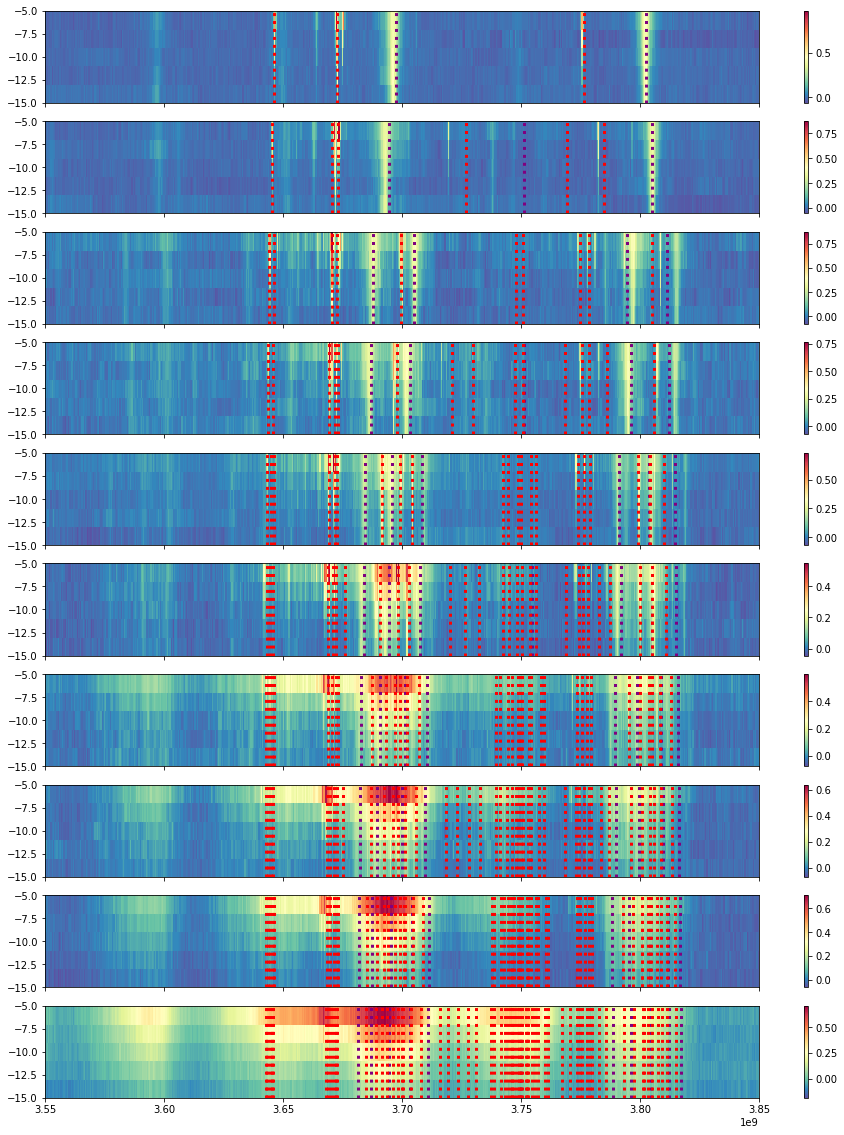

In [14]:
min_num_qubits = 2
max_num_qubits = 11
simulation_qubit_num = 11
fig, axes = plt.subplots(max_num_qubits-min_num_qubits+1,1, figsize=(16, 20), sharex=True)
for num_qubits in tqdm(range(min_num_qubits, max_num_qubits+1)):
    try:
        m = exdir_db_inst.select_measurement(measurement_type='two_tone_11q_power', 
                                             metadata={'num_resonant_qubits':num_qubits,
                                                       'resonator_id':'1'})
    except:
        raise
    
    coil_voltages = {}
    for coil, voltage in m.metadata.items():
        if coil[:6] == 'NNDAC-':
            if int(coil[6:]) in coil_qubits.keys():
                coil_voltages[coil_qubits[int(coil[6:])]] = float(voltage)
    coil_voltages_vec = [coil_voltages[qubit_id] for qubit_id in coil_qubits.values()]
    
    qubit_frequencies = []
    for qubit_id_, qubit_id in enumerate(coil_qubits.values()):
        qubit_flux = (inductance_matrix@coil_voltages_vec)[qubit_id_]+params['phi0'][qubit_id]
        qubit_frequencies.append(fqbare(params['EJ1'][qubit_id], params['EJ2'][qubit_id], params['EC'], qubit_flux))
    
    #print(qubit_frequencies)
    
    #print (coil_voltages)
    simulation_qubit_num = num_qubits
    vals, vecs_ = simulate_non_driven_frequencies(simulation_qubit_num, qubit_frequencies, J1, J2)
    f01 = vals[1:simulation_qubit_num+1]-vals[0]
    f02h = np.asarray(vals[simulation_qubit_num+1:]-vals[0])/2
#     print (vals)
    # thresholding by qubit 1 popluation
    #print ('Single-photon transitions:', f01)
    #print ('Two-photon transitions:', f02h)
    try:
        #m = exdir_db_inst.select_measurement(measurement_type='two_tone_11q_power', metadata={'num_resonant_qubits':num_qubits})
        x = m.datasets['S-parameter'].parameters[1].values
        y = m.datasets['S-parameter'].parameters[0].values
        #z = np.abs(m.datasets['S-parameter'].data_squeezed)
        z_cmplx = m.datasets['S-parameter'].data_squeezed
        med = np.median(np.real(z_cmplx))+1j*np.median(np.imag(z_cmplx))
        z_nomed = z_cmplx-med
        
        r = np.real(z_nomed.ravel())
        i = np.imag(z_nomed.ravel())
        
        m = np.asarray([[np.mean(r*r), np.mean(r*i)],[np.mean(r*i), np.mean(i*i)]])
        vals, vecs = np.linalg.eigh(m)
        best_index = np.argmax(vals)
        component = vecs[best_index,:]
        
        z = np.real(z_nomed*np.conj(component[0]+1j*component[1]))
        z = z/np.max(z)
        
        im = axes[num_qubits-min_num_qubits].pcolormesh(x,y,z, cmap='Spectral_r')
        axes[num_qubits-min_num_qubits].set_xlim(3.55e9, 3.85e9)
        plt.colorbar(im, ax=axes[num_qubits-min_num_qubits])
        #axes[num_qubits-min_num_qubits].scatter(np.real(z), np.imag(z))
        for qubit_id in range(simulation_qubit_num):
            axes[num_qubits-min_num_qubits].axvline(f01[qubit_id], color='purple', linestyle=':', linewidth=3)
            
        for transition_id in range((simulation_qubit_num*(simulation_qubit_num+1)//2)):
            axes[num_qubits-min_num_qubits].axvline(f02h[transition_id], color='red', linestyle=':', linewidth=3)
        
        #if num_qubits % 2:
        #    probabilities = np.abs(vecs_[(num_qubits+1)//2])**2
        #    populations = []
        #    for qubit_id in range(num_qubits):
                
        #    populations.append(np.reshape(probabilities, probabilities.dims[0])[
        #    ,...])
        #    probabilities = 
        #    axes[num_qubits-min_num_qubits,1].bar()
        
    except:
        raise
# plt.savefig('two_tone_11q_power_1q_readout_1q_signal')
plt.show()

In [13]:
%matplotlib qt5

In [14]:
from tqdm import tqdm
min_num_qubits = 7
max_num_qubits = 8
simulation_qubit_num = 8
fig, axes = plt.subplots(max_num_qubits-min_num_qubits+1,1, figsize=(8, 8), sharex=True)
for num_qubits in tqdm(range(min_num_qubits, max_num_qubits+1)):
    try:
        m = exdir_db_inst.select_measurement(measurement_type='two_tone', 
                                             metadata={'num_resonant_qubits':num_qubits,
                                                       'resonator_id':'1'})
    except:
        raise
    
    coil_voltages = {}
    for coil, voltage in m.metadata.items():
        if coil[:6] == 'NNDAC-':
            if int(coil[6:]) in coil_qubits.keys():
                coil_voltages[coil_qubits[int(coil[6:])]] = float(voltage)
    coil_voltages_vec = [coil_voltages[qubit_id] for qubit_id in coil_qubits.values()]
    
    qubit_frequencies = []
    for qubit_id_, qubit_id in enumerate(coil_qubits.values()):
        qubit_flux = (inductance_matrix@coil_voltages_vec)[qubit_id_]+params['phi0'][qubit_id]
        qubit_frequencies.append(fqbare(params['EJ1'][qubit_id], params['EJ2'][qubit_id], params['EC'], qubit_flux))
    
    #print(qubit_frequencies)
    
    #print (coil_voltages)
    simulation_qubit_num = num_qubits
    vals, vecs_ = simulate_non_driven_frequencies(simulation_qubit_num, qubit_frequencies, J1, J2)
    f01 = vals[1:simulation_qubit_num+1]-vals[0]
    f02h = np.asarray(vals[simulation_qubit_num+1:]-vals[0])/2
#     print (vals)
    # thresholding by qubit 1 popluation
    #print ('Single-photon transitions:', f01)
    #print ('Two-photon transitions:', f02h)
    try:
        #m = exdir_db_inst.select_measurement(measurement_type='two_tone_11q_power', metadata={'num_resonant_qubits':num_qubits})
        x = m.datasets['S-parameter'].parameters[1].values
        y = m.datasets['S-parameter'].parameters[0].values
        #z = np.abs(m.datasets['S-parameter'].data_squeezed)
        z_cmplx = m.datasets['S-parameter'].data_squeezed
        med = np.median(np.real(z_cmplx))+1j*np.median(np.imag(z_cmplx))
        z_nomed = z_cmplx-med
        
        r = np.real(z_nomed.ravel())
        i = np.imag(z_nomed.ravel())
        
        m = np.asarray([[np.mean(r*r), np.mean(r*i)],[np.mean(r*i), np.mean(i*i)]])
        vals, vecs = np.linalg.eigh(m)
        best_index = np.argmax(vals)
        component = vecs[best_index,:]
        
        z = np.real(z_nomed*np.conj(component[0]+1j*component[1]))
        z = z/np.max(z)
        
        #im = axes[num_qubits-min_num_qubits].pcolormesh(x,y,z, cmap='Spectral_r')
        axes[num_qubits-min_num_qubits].plot(x, np.nanmean(z, axis=0))
        axes[num_qubits-min_num_qubits].set_xlim(3.67e9, 3.885e9)
        #plt.colorbar(im, ax=axes[num_qubits-min_num_qubits])
        #axes[num_qubits-min_num_qubits].scatter(np.real(z), np.imag(z))
        for qubit_id in range(simulation_qubit_num):
            axes[num_qubits-min_num_qubits].axvline(f01[qubit_id], color='purple', linestyle=':', linewidth=3)
            
        #for transition_id in range((simulation_qubit_num*(simulation_qubit_num+1)//2)):
        #    axes[num_qubits-min_num_qubits].axvline(f02h[transition_id], color='red', linestyle=':', linewidth=3)
        
        #if num_qubits % 2:
        #    probabilities = np.abs(vecs_[(num_qubits+1)//2])**2
        #    populations = []
        #    for qubit_id in range(num_qubits):
                
        #    populations.append(np.reshape(probabilities, probabilities.dims[0])[
        #    ,...])
        #    probabilities = 
        #    axes[num_qubits-min_num_qubits,1].bar()
        
    except:
        raise
# plt.savefig('two_tone_11q_power_1q_readout_1q_signal')
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]


In [14]:
from tqdm import tqdm
num_qubits = 6
m = exdir_db_inst.select_measurement(measurement_type='two_tone', 
                                             metadata={'num_resonant_qubits':,
                                                       'resonator_id':'1'})

coil_voltages = {}
for coil, voltage in m.metadata.items():
    if coil[:6] == 'NNDAC-':
        if int(coil[6:]) in coil_qubits.keys():
            coil_voltages[coil_qubits[int(coil[6:])]] = float(voltage)
coil_voltages_vec = [coil_voltages[qubit_id] for qubit_id in coil_qubits.values()]
    
    qubit_frequencies = []
    for qubit_id_, qubit_id in enumerate(coil_qubits.values()):
        qubit_flux = (inductance_matrix@coil_voltages_vec)[qubit_id_]+params['phi0'][qubit_id]
        qubit_frequencies.append(fqbare(params['EJ1'][qubit_id], params['EJ2'][qubit_id], params['EC'], qubit_flux))
    
    #print(qubit_frequencies)
    
    #print (coil_voltages)
    simulation_qubit_num = num_qubits
    vals, vecs_ = simulate_non_driven_frequencies(simulation_qubit_num, qubit_frequencies, J1, J2)
    f01 = vals[1:simulation_qubit_num+1]-vals[0]
    f02h = np.asarray(vals[simulation_qubit_num+1:]-vals[0])/2
#     print (vals)
    # thresholding by qubit 1 popluation
    #print ('Single-photon transitions:', f01)
    #print ('Two-photon transitions:', f02h)
    try:
        #m = exdir_db_inst.select_measurement(measurement_type='two_tone_11q_power', metadata={'num_resonant_qubits':num_qubits})
        x = m.datasets['S-parameter'].parameters[1].values
        y = m.datasets['S-parameter'].parameters[0].values
        #z = np.abs(m.datasets['S-parameter'].data_squeezed)
        z_cmplx = m.datasets['S-parameter'].data_squeezed
        med = np.median(np.real(z_cmplx))+1j*np.median(np.imag(z_cmplx))
        z_nomed = z_cmplx-med
        
        r = np.real(z_nomed.ravel())
        i = np.imag(z_nomed.ravel())
        
        m = np.asarray([[np.mean(r*r), np.mean(r*i)],[np.mean(r*i), np.mean(i*i)]])
        vals, vecs = np.linalg.eigh(m)
        best_index = np.argmax(vals)
        component = vecs[best_index,:]
        
        z = np.real(z_nomed*np.conj(component[0]+1j*component[1]))
        z = z/np.max(z)
        
        #im = axes[num_qubits-min_num_qubits].pcolormesh(x,y,z, cmap='Spectral_r')
        axes[num_qubits-min_num_qubits].plot(x, np.nanmean(z, axis=0))
        axes[num_qubits-min_num_qubits].set_xlim(3.67e9, 3.885e9)
        #plt.colorbar(im, ax=axes[num_qubits-min_num_qubits])
        #axes[num_qubits-min_num_qubits].scatter(np.real(z), np.imag(z))
        for qubit_id in range(simulation_qubit_num):
            axes[num_qubits-min_num_qubits].axvline(f01[qubit_id], color='purple', linestyle=':', linewidth=3)
            
        #for transition_id in range((simulation_qubit_num*(simulation_qubit_num+1)//2)):
        #    axes[num_qubits-min_num_qubits].axvline(f02h[transition_id], color='red', linestyle=':', linewidth=3)
        
        #if num_qubits % 2:
        #    probabilities = np.abs(vecs_[(num_qubits+1)//2])**2
        #    populations = []
        #    for qubit_id in range(num_qubits):
                
        #    populations.append(np.reshape(probabilities, probabilities.dims[0])[
        #    ,...])
        #    probabilities = 
        #    axes[num_qubits-min_num_qubits,1].bar()
        
    except:
        raise
# plt.savefig('two_tone_11q_power_1q_readout_1q_signal')
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]


In [23]:
exdir_db_inst.select_measurement(measurement_type='two_tone', 
                                             metadata={'num_resonant_qubits':num_qubits,
                                                       'resonator_id':'1'}).id

5296

In [11]:
axes[num_qubits-min_num_qubits].axvline

<bound method Axes.axvline of <matplotlib.axes._subplots.AxesSubplot object at 0x0000017FD8522F60>>

In [12]:
vecs_[(num_qubits+1)//2].dims[0]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [35]:
from tqdm import tqdm
curve_fit?

In [67]:
from scipy.optimize import curve_fit
m = exdir_db_inst.select_measurement_by_id(5397)
x = m.datasets['S-parameter'].parameters[0].values
y = m.datasets['S-parameter'].data
p0=(3.5400, 1.3e-4, -0.01, -0.01)
def fitfunc (x,f0,df,A,B): 
    #print (f0, df, A, B)
    #print (A-np.real((1j+1)*B/(x-f0+1j*df)))
    return A+np.real(1j*B*df/(x-f0+1j*df))
fitresults = curve_fit(fitfunc, x/1e9, np.real(y).ravel(), p0=p0, maxfev=10000)
plt.plot(x/1e9,np.real(y), marker='o', linestyle='')
y_fit = fitfunc(x/1e9, *fitresults[0])
plt.plot(x/1e9, y_fit, linewidth=4)
plt.savefig(r'C:\tupoye-govno\lorentz.svg')
fitresults

Exdir_db.select_measurement_by_id: trying to load measurement state by id:  d:\data\2019-12-14\005397-Simple_two_tone_spectroscopy-11qubits_021119_2


(array([ 3.53992195e+00,  1.75348375e-04, -1.53090812e-02, -9.89716742e-03]),
 array([[ 2.29372169e-10, -7.19633882e-14, -3.87496293e-14,
         -2.92834379e-12],
        [-7.19633882e-14,  5.13641121e-10,  8.28505294e-10,
          1.28736314e-08],
        [-3.87496293e-14,  8.28505294e-10,  1.25212989e-08,
         -1.10812249e-09],
        [-2.92834379e-12,  1.28736314e-08, -1.10812249e-09,
          7.30754862e-07]]))

In [33]:
min_num_qubits = 1
max_num_qubits = 11
simulation_qubit_num = 11
fig, axes = plt.subplots(max_num_qubits-min_num_qubits+1,1, figsize=(16, 20), sharex=True)
for num_qubits in tqdm(range(min_num_qubits, max_num_qubits+1)):
    
    try:
        m = exdir_db_inst.select_measurement(measurement_type='two_tone_11q_power_paper', 
                                             metadata={'num_resonant_qubits':num_qubits,
                                                       'resonator_id':'6'})
    except:
        continue
    
    coil_voltages = {}
    for coil, voltage in m.metadata.items():
        if coil[:6] == 'NNDAC-':
            if int(coil[6:]) in coil_qubits.keys():
                coil_voltages[coil_qubits[int(coil[6:])]] = float(voltage)
    coil_voltages_vec = [coil_voltages[qubit_id] for qubit_id in coil_qubits.values()]
    
    qubit_frequencies = []
    for qubit_id_, qubit_id in enumerate(coil_qubits.values()):
        qubit_flux = (inductance_matrix@coil_voltages_vec)[qubit_id_]+params['phi0'][qubit_id]
        qubit_frequencies.append(fqbare(params['EJ1'][qubit_id], params['EJ2'][qubit_id], params['EC'], qubit_flux))
    
    #print(qubit_frequencies)
    
    #print (coil_voltages)
    simulation_qubit_num = num_qubits
    vals, vecs_ = simulate_non_driven_frequencies(simulation_qubit_num, qubit_frequencies[::-1], J2, J1)
    f01 = vals[1:simulation_qubit_num+1]-vals[0]
    f02h = np.asarray(vals[simulation_qubit_num+1:]-vals[0])/2
#     print (vals)
    # thresholding by qubit 1 popluation
    #print ('Single-photon transitions:', f01)
    #print ('Two-photon transitions:', f02h)
    try:
        #m = exdir_db_inst.select_measurement(measurement_type='two_tone_11q_power', metadata={'num_resonant_qubits':num_qubits})
        x = m.datasets['S-parameter'].parameters[1].values
        y = m.datasets['S-parameter'].parameters[0].values
        #z = np.abs(m.datasets['S-parameter'].data_squeezed)
        z_cmplx = m.datasets['S-parameter'].data_squeezed
        med = np.median(np.real(z_cmplx))+1j*np.median(np.imag(z_cmplx))
        z_nomed = z_cmplx-med
        
        r = np.real(z_nomed.ravel())
        i = np.imag(z_nomed.ravel())
        
        m = np.asarray([[np.mean(r*r), np.mean(r*i)],[np.mean(r*i), np.mean(i*i)]])
        vals, vecs = np.linalg.eigh(m)
        best_index = np.argmax(vals)
        component = vecs[best_index,:]
        
        z = np.real(z_nomed*np.conj(component[0]+1j*component[1]))
        z = z/np.max(z)
        
        im = axes[num_qubits-min_num_qubits].plot(y,z)
        axes[num_qubits-min_num_qubits].set_xlim(3.55e9, 3.85e9)
#         plt.colorbar(im, ax=axes[num_qubits-min_num_qubits])
        #axes[num_qubits-min_num_qubits].scatter(np.real(z), np.imag(z))
        for qubit_id in range(simulation_qubit_num):
            axes[num_qubits-min_num_qubits].axvline(f01[qubit_id], color='purple', linestyle=':', linewidth=3)
            
#         for transition_id in range((simulation_qubit_num*(simulation_qubit_num+1)//2)):
#             axes[num_qubits-min_num_qubits].axvline(f02h[transition_id], color='red', linestyle=':', linewidth=3)
        
        #if num_qubits % 2:
        #    probabilities = np.abs(vecs_[(num_qubits+1)//2])**2
        #    populations = []
        #    for qubit_id in range(num_qubits):
                
        #    populations.append(np.reshape(probabilities, probabilities.dims[0])[
        #    ,...])
        #    probabilities = 
        #    axes[num_qubits-min_num_qubits,1].bar()
        
    except:
        raise



  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

  9%|███████▌                                                                           | 1/11 [00:01<00:14,  1.50s/it]

 18%|███████████████                                                                    | 2/11 [00:02<00:11,  1.23s/it]

 27%|██████████████████████▋                                                            | 3/11 [00:02<00:08,  1.03s/it]

 36%|██████████████████████████████▏                                                    | 4/11 [00:03<00:06,  1.16it/s]

 45%|█████████████████████████████████████▋                                             | 5/11 [00:03<00:04,  1.33it/s]

 55%|█████████████████████████████████████████████▎                                     | 6/11 [00:04<00:03,  1.41it/s]

 64%|████████████████████████████████████████████████████▊                              | 7/11 [00:05<00:02,  1.37it/s]

 73%|█████████████████████████

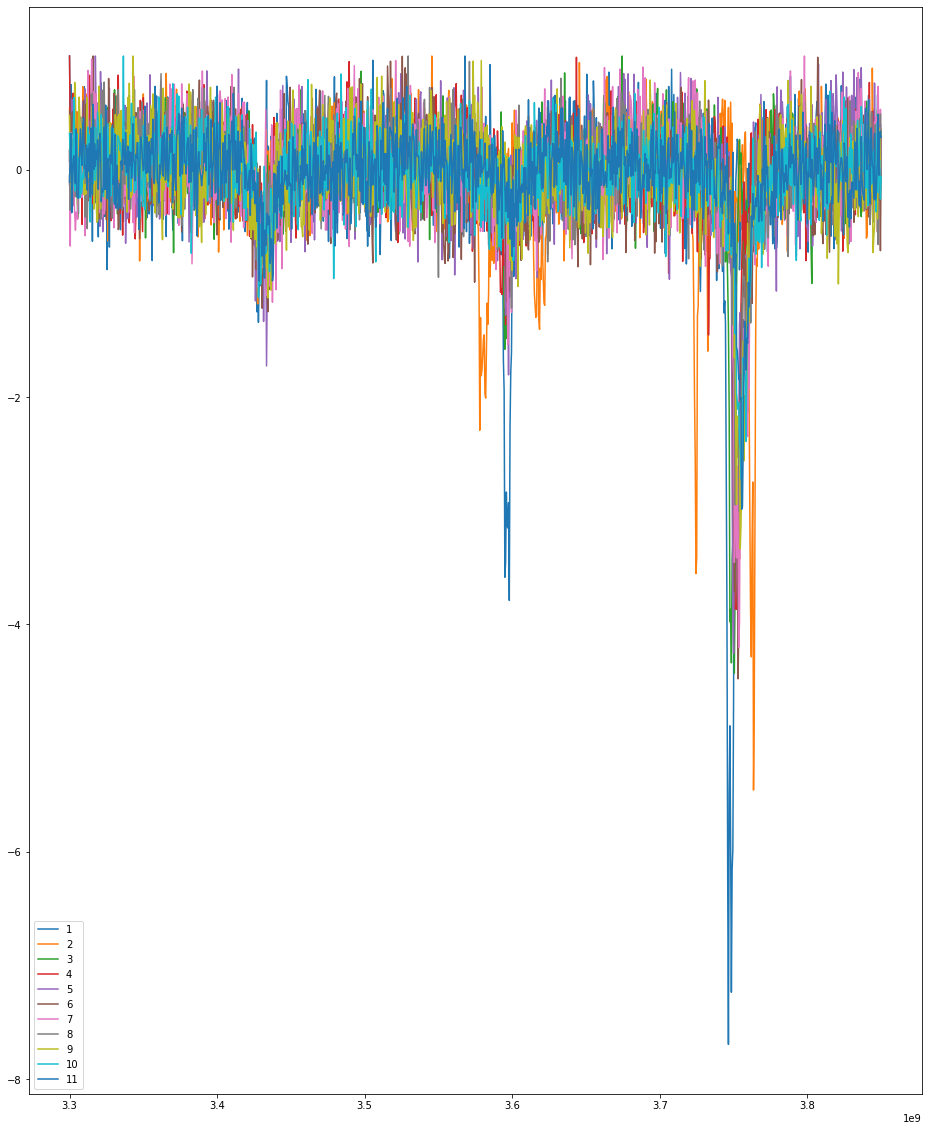

In [49]:
fig, axes = plt.subplots(1,1, figsize=(16, 20))
for i in range(11):
    axes.plot(y,all_measurements[i],label=str(i+1))
plt.legend()

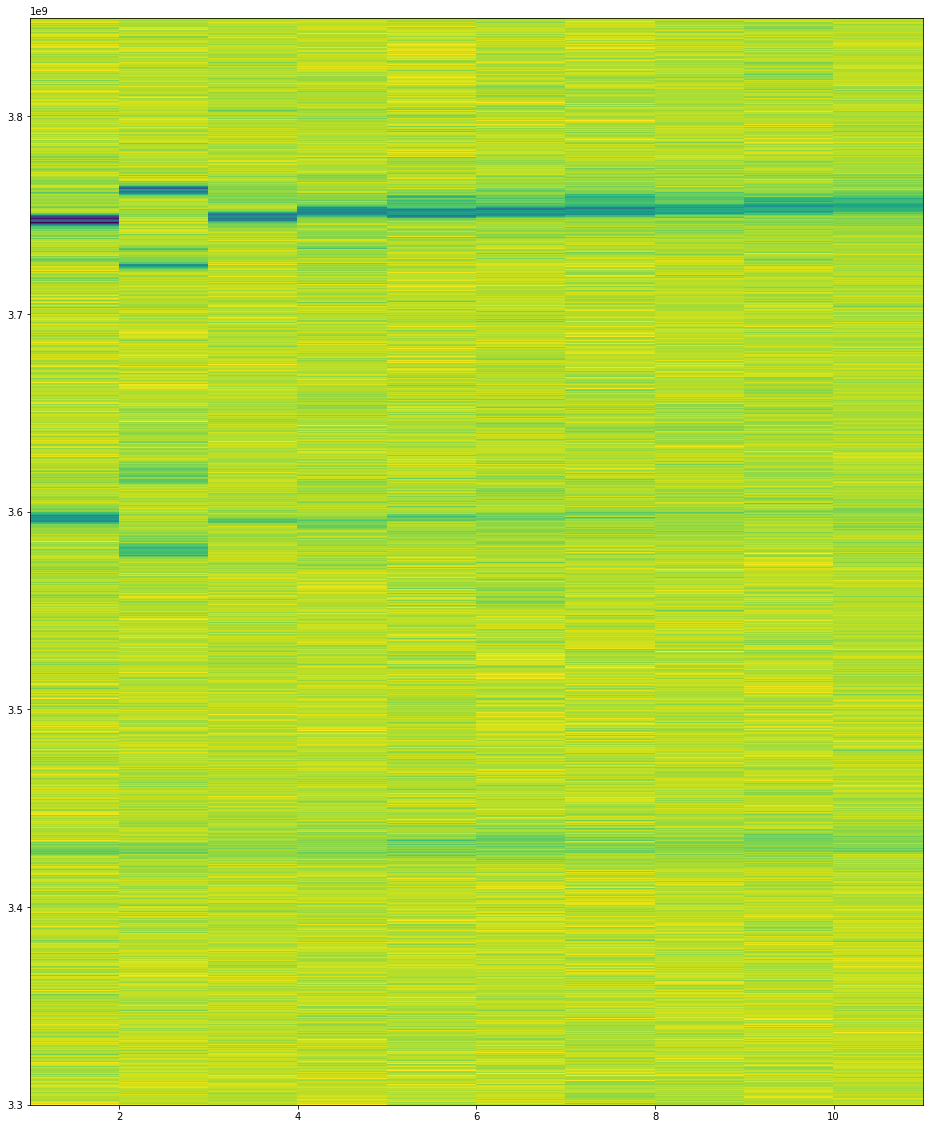

In [50]:
fig, axes = plt.subplots(1,1, figsize=(16, 20))
axes.pcolormesh(np.linspace(1,11,11),y,np.asarray(all_measurements).T)

In [22]:
%matplotlib qt5

In [24]:
min_num_qubits = 1
max_num_qubits = 7
simulation_qubit_num = 11
all_measurements=[]
fig, axes = plt.subplots(max_num_qubits-min_num_qubits+1,1, figsize=(16, 20), sharex=True)
for num_qubits in tqdm(range(min_num_qubits,max_num_qubits+1)):
    try:
        m = exdir_db_inst.select_measurement(measurement_type='two_tone_11q_power_paper', 
                                             metadata={'num_resonant_qubits': num_qubits,
                                                       'resonator_id':'10'})
    except:
        continue
        
    coil_voltages = {}
    for coil, voltage in m.metadata.items():
        if coil[:6] == 'NNDAC-':
            if int(coil[6:]) in coil_qubits.keys():
                coil_voltages[coil_qubits[int(coil[6:])]] = float(voltage)
    coil_voltages_vec = [coil_voltages[qubit_id] for qubit_id in coil_qubits.values()]
    
    qubit_frequencies = []
    for qubit_id_, qubit_id in enumerate(coil_qubits.values()):
        qubit_flux = (inductance_matrix@coil_voltages_vec)[qubit_id_]+params['phi0'][qubit_id]
        qubit_frequencies.append(fqbare(params['EJ1'][qubit_id], params['EJ2'][qubit_id], params['EC'], qubit_flux))
    
    #print(qubit_frequencies)
    
    #print (coil_voltages)
    simulation_qubit_num = num_qubits
    vals, vecs_ = simulate_non_driven_frequencies(simulation_qubit_num, qubit_frequencies[::-1], J2, J1)
    f01 = vals[1:simulation_qubit_num+1]-vals[0]
    f02h = np.asarray(vals[simulation_qubit_num+1:]-vals[0])/2
    
    try:
        x = m.datasets['S-parameter'].parameters[1].values
        y = m.datasets['S-parameter'].parameters[0].values
        z_cmplx = m.datasets['S-parameter'].data_squeezed
        med = np.median(np.real(z_cmplx))+1j*np.median(np.imag(z_cmplx))
        z_nomed = z_cmplx-med
        
        r = np.real(z_nomed.ravel())
        i = np.imag(z_nomed.ravel())
        
        m = np.asarray([[np.mean(r*r), np.mean(r*i)],[np.mean(r*i), np.mean(i*i)]])
        vals, vecs = np.linalg.eigh(m)
        best_index = np.argmax(vals)
        component = vecs[best_index,:]
        
        z = np.real(z_nomed*np.conj(component[0]+1j*component[1]))
        z = z/np.max(z)
        all_measurements.append(z)
#         plt.pcolormesh(x,y,z, cmap='Spectral_r')
        im = axes[num_qubits-min_num_qubits].plot(y,z)
        axes[num_qubits-min_num_qubits].set_xlim(3.55e9, 3.85e9)
#         plt.colorbar(im, ax=axes[num_qubits-min_num_qubits])
        for qubit_id in range(simulation_qubit_num):
            axes[num_qubits-min_num_qubits].axvline(f01[qubit_id], color='purple', linestyle=':', linewidth=3)
         
    except:
        raise
plt.savefig('two_tone_11q_power_1q_readout_1q_signal_1tone')
plt.show()


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.16it/s]

### readout of the 10 resonator with pump applied on the 11 qubit 

In [6]:
from tqdm import tqdm

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

[4032242135.698283, 3878847324.858663, 3997701588.0414944, 3905302395.6004486, 3876696313.520456, 3822947733.9470825, 4015772046.0845475, 3916840183.7858567, 3998926288.6972322, 3749851216.128782, 3749925776.7974086]


 10%|████████▎                                                                          | 1/10 [00:00<00:03,  2.26it/s]

[4032242135.698283, 3878847324.858663, 3997701588.0414944, 3905302395.6004486, 3876696313.520456, 3822947733.9470825, 4015772046.0845475, 3916221931.6115675, 3749228957.1599483, 3750177052.8802123, 3749925776.7974086]


 20%|████████████████▌                                                                  | 2/10 [00:00<00:03,  2.27it/s]

[4032242135.698283, 3878847324.858663, 3997701588.0414944, 3905302395.6004486, 3876696313.520456, 3822947733.9470825, 4013675310.6035166, 3747643185.6944814, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 30%|████████████████████████▉                                                          | 3/10 [00:01<00:03,  2.26it/s]

[4032242135.698283, 3878847324.858663, 3997701588.0414944, 3905302395.6004486, 3876696313.520456, 3822521873.922861, 3749596300.8648376, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 40%|█████████████████████████████████▏                                                 | 4/10 [00:01<00:02,  2.23it/s]

[4032242135.698283, 3878847324.858663, 3997701588.0414944, 3905302395.6004486, 3875797588.6973796, 3749639379.602891, 3750039718.635878, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:02,  2.10it/s]

[4032242135.698283, 3878847324.858663, 3997701588.0414944, 3905074347.841985, 3748786496.613612, 3750037907.857356, 3750039718.635878, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.80it/s]

[4032242135.698283, 3878847324.858663, 3997094918.840846, 3749262812.0635324, 3749867143.935814, 3750037907.857356, 3750039718.635878, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:06<00:04,  1.46s/it]

[4032242135.698283, 3878716013.7978024, 3748677145.6831827, 3750172790.743899, 3749867143.935814, 3750037907.857356, 3750039718.635878, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:13<00:06,  3.18s/it]

[4031829870.648142, 3748047780.1208863, 3749813165.723134, 3750172790.743899, 3749867143.935814, 3750037907.857356, 3750039718.635878, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:49<00:13, 13.01s/it]

[3750035102.423915, 3750023305.7793055, 3749813165.723134, 3750172790.743899, 3749867143.935814, 3750037907.857356, 3750039718.635878, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:43<00:00, 61.32s/it]


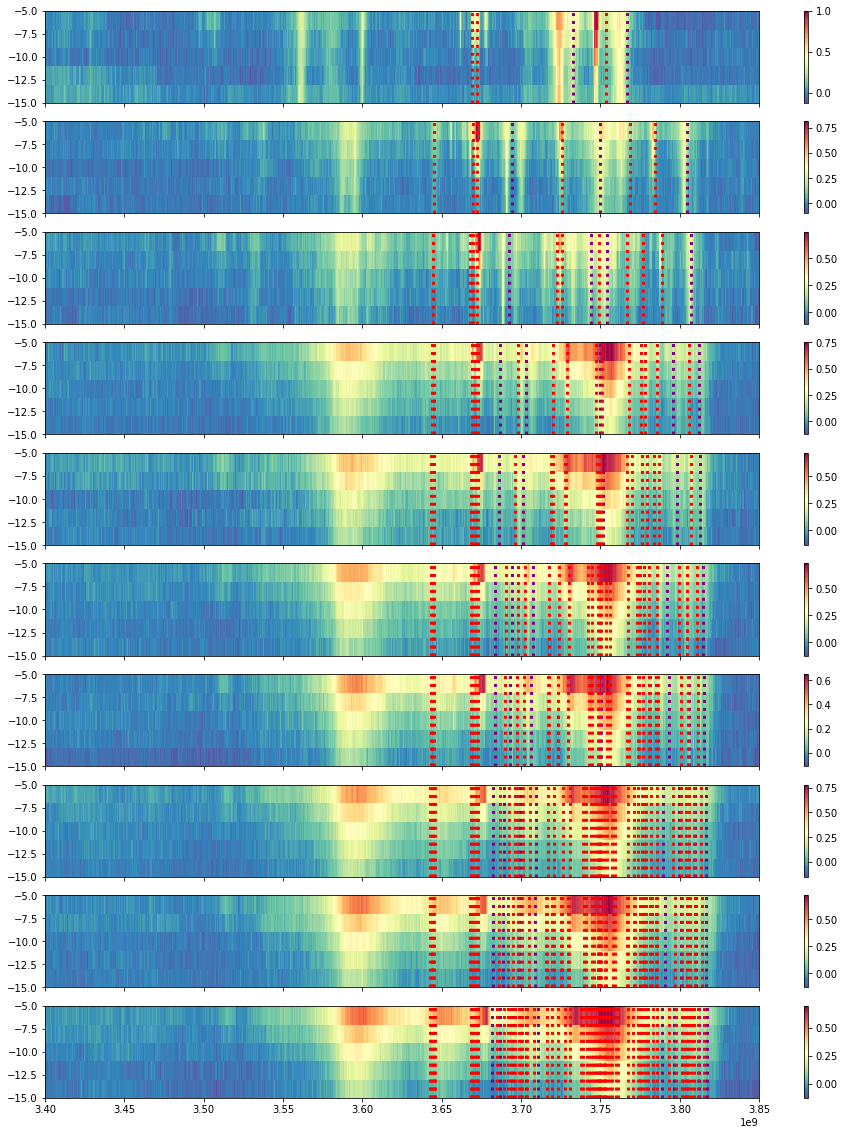

In [17]:
min_num_qubits = 2
max_num_qubits = 11
simulation_qubit_num = 11
fig, axes = plt.subplots(max_num_qubits-min_num_qubits+1,1, figsize=(16, 20), sharex=True)
for num_qubits in tqdm(range(min_num_qubits, max_num_qubits+1)):
    try:
        # Ivan : made 12-num
        m = exdir_db_inst.select_measurement(measurement_type='two_tone_11q_power', 
                                             metadata={'num_resonant_qubits':12-num_qubits,
                                                       'resonator_id':'10'})
    except:
        raise
    coil_voltages = {}
    for coil, voltage in m.metadata.items():
        if coil[:6] == 'NNDAC-':
            if int(coil[6:]) in coil_qubits.keys():
                coil_voltages[coil_qubits[int(coil[6:])]] = float(voltage)
    coil_voltages_vec = [coil_voltages[qubit_id] for qubit_id in coil_qubits.values()]
    qubit_frequencies = []
    for qubit_id_, qubit_id in enumerate(coil_qubits.values()):
        qubit_flux = (inductance_matrix@coil_voltages_vec)[qubit_id_]+params['phi0'][qubit_id]
        qubit_frequencies.append(fqbare(params['EJ1'][qubit_id], params['EJ2'][qubit_id], params['EC'], qubit_flux))
    
    print(qubit_frequencies)
    
    #print (coil_voltages)
    simulation_qubit_num = num_qubits
    # Ivan : made reverse order
    vals, vecs_ = simulate_non_driven_frequencies(simulation_qubit_num, qubit_frequencies[::-1], J2, J1)
    f01 = vals[1:simulation_qubit_num+1]-vals[0]
#     print(f01)
    f02h = np.asarray(vals[simulation_qubit_num+1:]-vals[0])/2
    # thresholding by qubit 1 popluation
    #print ('Single-photon transitions:', f01)
    #print ('Two-photon transitions:', f02h)
    try:
        #m = exdir_db_inst.select_measurement(measurement_type='two_tone_11q_power', metadata={'num_resonant_qubits':num_qubits})
        x = m.datasets['S-parameter'].parameters[1].values
        y = m.datasets['S-parameter'].parameters[0].values
        #z = np.abs(m.datasets['S-parameter'].data_squeezed)
        z_cmplx = m.datasets['S-parameter'].data_squeezed
        med = np.median(np.real(z_cmplx))+1j*np.median(np.imag(z_cmplx))
        z_nomed = z_cmplx-med
        
        r = np.real(z_nomed.ravel())
        i = np.imag(z_nomed.ravel())
        
        m = np.asarray([[np.mean(r*r), np.mean(r*i)],[np.mean(r*i), np.mean(i*i)]])
        vals, vecs = np.linalg.eigh(m)
        best_index = np.argmax(vals)
        component = vecs[best_index,:]
        
        z = np.real(z_nomed*np.conj(component[0]+1j*component[1]))
        z = z/np.max(z)
        
        im = axes[num_qubits-min_num_qubits].pcolormesh(x,y,z, cmap='Spectral_r')
        axes[num_qubits-min_num_qubits].set_xlim(3.4e9, 3.85e9)
        plt.colorbar(im, ax=axes[num_qubits-min_num_qubits])
        #axes[num_qubits-min_num_qubits].scatter(np.real(z), np.imag(z))
        for qubit_id in range(simulation_qubit_num):
            axes[num_qubits-min_num_qubits].axvline(f01[qubit_id], color='purple', linestyle=':', linewidth=3)
            
        for transition_id in range((simulation_qubit_num*(simulation_qubit_num+1)//2)):
            axes[num_qubits-min_num_qubits].axvline(f02h[transition_id], color='red', linestyle=':', linewidth=3)
        
        #if num_qubits % 2:
        #    probabilities = np.abs(vecs_[(num_qubits+1)//2])**2
        #    populations = []
        #    for qubit_id in range(num_qubits):
                
        #    populations.append(np.reshape(probabilities, probabilities.dims[0])[
        #    ,...])
        #    probabilities = 
        #    axes[num_qubits-min_num_qubits,1].bar()
        
    except:
        raise
plt.savefig('two_tone_11q_power_10q_readout_11q_signal')
plt.show()

### readout of the 11 resonator with pump applied on the 11 qubit 

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

[4032242135.698283, 3878847324.858663, 3997701588.0414944, 3905302395.6004486, 3876696313.520456, 3822947733.9470825, 4015772046.0845475, 3916840183.7858567, 3998926288.6972322, 3749851216.128782, 3749925776.7974086]


 10%|████████▎                                                                          | 1/10 [00:00<00:03,  2.33it/s]

[4032242135.698283, 3878847324.858663, 3997701588.0414944, 3905302395.6004486, 3876696313.520456, 3822947733.9470825, 4015772046.0845475, 3916221931.6115675, 3749228957.1599483, 3750177052.8802123, 3749925776.7974086]


 20%|████████████████▌                                                                  | 2/10 [00:00<00:03,  2.32it/s]

[4032242135.698283, 3878847324.858663, 3997701588.0414944, 3905302395.6004486, 3876696313.520456, 3822947733.9470825, 4013675310.6035166, 3747643185.6944814, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 30%|████████████████████████▉                                                          | 3/10 [00:01<00:03,  2.28it/s]

[4032242135.698283, 3878847324.858663, 3997701588.0414944, 3905302395.6004486, 3876696313.520456, 3822521873.922861, 3749596300.8648376, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 40%|█████████████████████████████████▏                                                 | 4/10 [00:01<00:02,  2.23it/s]

[4032242135.698283, 3878847324.858663, 3997701588.0414944, 3905302395.6004486, 3875797588.6973796, 3749639379.602891, 3750039718.635878, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:02,  2.08it/s]

[4032242135.698283, 3878847324.858663, 3997701588.0414944, 3905074347.841985, 3748786496.613612, 3750037907.857356, 3750039718.635878, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.83it/s]

[4032242135.698283, 3878847324.858663, 3997094918.840846, 3749262812.0635324, 3749867143.935814, 3750037907.857356, 3750039718.635878, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:06<00:04,  1.53s/it]

[4032242135.698283, 3878716013.7978024, 3748677145.6831827, 3750172790.743899, 3749867143.935814, 3750037907.857356, 3750039718.635878, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:14<00:06,  3.47s/it]

[4031829870.648142, 3748047780.1208863, 3749813165.723134, 3750172790.743899, 3749867143.935814, 3750037907.857356, 3750039718.635878, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:00<00:16, 16.17s/it]

[3750035102.423915, 3750023305.7793055, 3749813165.723134, 3750172790.743899, 3749867143.935814, 3750037907.857356, 3750039718.635878, 3749815687.34273, 3750024628.961357, 3750177052.8802123, 3749925776.7974086]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:56<00:00, 64.10s/it]


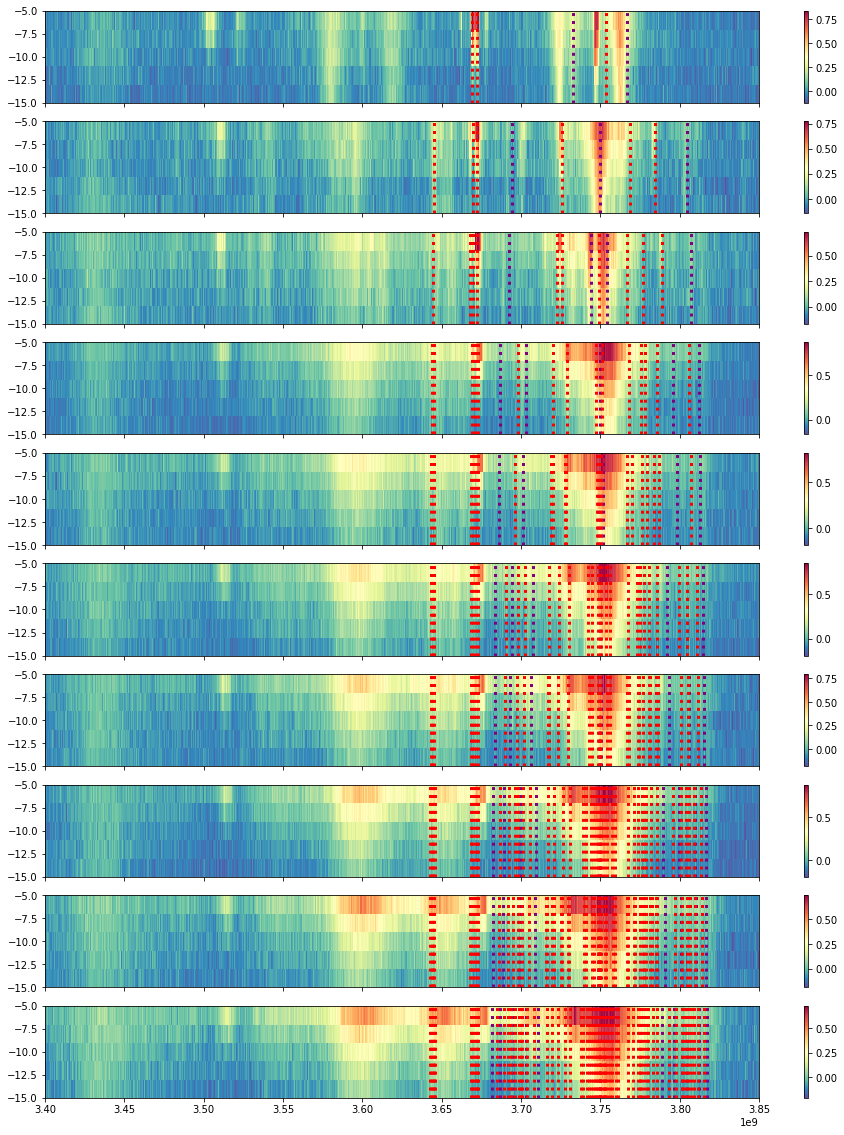

In [16]:
min_num_qubits = 2
max_num_qubits = 11
simulation_qubit_num = 11
fig, axes = plt.subplots(max_num_qubits-min_num_qubits+1,1, figsize=(16, 20), sharex=True)
for num_qubits in tqdm(range(min_num_qubits, max_num_qubits+1)):
    try:
        # Ivan : made 12-num
        m = exdir_db_inst.select_measurement(measurement_type='two_tone_11q_power', 
                                             metadata={'num_resonant_qubits':12-num_qubits,
                                                       'resonator_id':'11'})
    except:
        raise
    coil_voltages = {}
    for coil, voltage in m.metadata.items():
        if coil[:6] == 'NNDAC-':
            if int(coil[6:]) in coil_qubits.keys():
                coil_voltages[coil_qubits[int(coil[6:])]] = float(voltage)
    coil_voltages_vec = [coil_voltages[qubit_id] for qubit_id in coil_qubits.values()]
    qubit_frequencies = []
    for qubit_id_, qubit_id in enumerate(coil_qubits.values()):
        qubit_flux = (inductance_matrix@coil_voltages_vec)[qubit_id_]+params['phi0'][qubit_id]
        qubit_frequencies.append(fqbare(params['EJ1'][qubit_id], params['EJ2'][qubit_id], params['EC'], qubit_flux))
    
    print(qubit_frequencies)
    
    #print (coil_voltages)
    simulation_qubit_num = num_qubits
    # Ivan : made reverse order
    vals, vecs_ = simulate_non_driven_frequencies(simulation_qubit_num, qubit_frequencies[::-1], J2, J1)
    f01 = vals[1:simulation_qubit_num+1]-vals[0]
#     print(f01)
    f02h = np.asarray(vals[simulation_qubit_num+1:]-vals[0])/2
    # thresholding by qubit 1 popluation
    #print ('Single-photon transitions:', f01)
    #print ('Two-photon transitions:', f02h)
    try:
        #m = exdir_db_inst.select_measurement(measurement_type='two_tone_11q_power', metadata={'num_resonant_qubits':num_qubits})
        x = m.datasets['S-parameter'].parameters[1].values
        y = m.datasets['S-parameter'].parameters[0].values
        #z = np.abs(m.datasets['S-parameter'].data_squeezed)
        z_cmplx = m.datasets['S-parameter'].data_squeezed
        med = np.median(np.real(z_cmplx))+1j*np.median(np.imag(z_cmplx))
        z_nomed = z_cmplx-med
        
        r = np.real(z_nomed.ravel())
        i = np.imag(z_nomed.ravel())
        
        m = np.asarray([[np.mean(r*r), np.mean(r*i)],[np.mean(r*i), np.mean(i*i)]])
        vals, vecs = np.linalg.eigh(m)
        best_index = np.argmax(vals)
        component = vecs[best_index,:]
        
        z = np.real(z_nomed*np.conj(component[0]+1j*component[1]))
        z = z/np.max(z)
        
        im = axes[num_qubits-min_num_qubits].pcolormesh(x,y,z, cmap='Spectral_r')
        axes[num_qubits-min_num_qubits].set_xlim(3.4e9, 3.85e9)
        plt.colorbar(im, ax=axes[num_qubits-min_num_qubits])
        #axes[num_qubits-min_num_qubits].scatter(np.real(z), np.imag(z))
        for qubit_id in range(simulation_qubit_num):
            axes[num_qubits-min_num_qubits].axvline(f01[qubit_id], color='purple', linestyle=':', linewidth=3)
            
        for transition_id in range((simulation_qubit_num*(simulation_qubit_num+1)//2)):
            axes[num_qubits-min_num_qubits].axvline(f02h[transition_id], color='red', linestyle=':', linewidth=3)
        
        #if num_qubits % 2:
        #    probabilities = np.abs(vecs_[(num_qubits+1)//2])**2
        #    populations = []
        #    for qubit_id in range(num_qubits):
                
        #    populations.append(np.reshape(probabilities, probabilities.dims[0])[
        #    ,...])
        #    probabilities = 
        #    axes[num_qubits-min_num_qubits,1].bar()
        
    except:
        raise
plt.savefig('two_tone_11q_power_11q_readout_11q_signal')    
plt.show()

In [28]:
def data_processing(resonator_id,num_resonant_qubits=11,mtype='two_tone_11q_power_paper'):
    m = exdir_db_inst.select_measurement(measurement_type=mtype, 
                                                 metadata={'num_resonant_qubits': num_resonant_qubits,
                                                           'resonator_id':resonator_id})
    x = m.datasets['S-parameter'].parameters[1].values
    y = m.datasets['S-parameter'].parameters[0].values
    z_cmplx = m.datasets['S-parameter'].data_squeezed
    med = np.median(np.real(z_cmplx))+1j*np.median(np.imag(z_cmplx))
    z_nomed = z_cmplx-med

    r = np.real(z_nomed.ravel())
    i = np.imag(z_nomed.ravel())

    m = np.asarray([[np.mean(r*r), np.mean(r*i)],[np.mean(r*i), np.mean(i*i)]])
    vals, vecs = np.linalg.eigh(m)
    best_index = np.argmax(vals)
    component = vecs[best_index,:]

    z = np.real(z_nomed*np.conj(component[0]+1j*component[1]))
    z = z/np.max(z)
    return y,z

построить одномерные
скатер плот
в симуляции лоу энерджи сабспейс


In [33]:
from scipy.signal import savgol_filter

In [78]:
fig, axes = plt.subplots(5,1, figsize=(8, 8), sharex=True)
x1,y1=data_processing('11','11',mtype='two_tone_11q_power_paper')
# x2,y2=data_processing('6','11',mtype='two_tone_11q_power_paper')
x2,y2=data_processing('1','11',mtype='two_tone_11q_power_paper')
x3,y3=data_processing('11','11',mtype='two_tone_11q_1q_power_paper')
x4,y4=data_processing('1','10',mtype='two_tone_11q_1q_power_paper')
x5,y5=data_processing('1','11',mtype='two_tone_11q_1q_power_paper')
points=500
axes[0].plot(x1[points:],y1[points:])
axes[1].plot(x2[points:],y2[points:])
axes[2].plot(x3[points:],y3[points:])
axes[3].plot(x4[points:],y4[points:])
axes[4].plot(x5[points:],y5[points:])
plt.plot()

[]

In [77]:
%matplotlib qt5

In [75]:
np.std(y4[:500])

0.2582344648521313

In [76]:
np.min(y4)

-1.9804615348696684

In [ ]:
x4,y4=data_processing('1','11',mtype='two_tone_11q_1q_power_paper')


In [34]:
x,y,z=data_processing('11','11',mtype='two_tone_11q_power_paper')

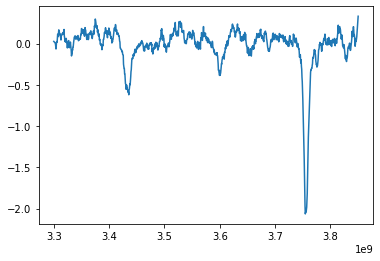

In [40]:
plt.plot(y,savgol_filter(z,11,1))

In [47]:
x,y,z=data_processing('1','11',mtype='two_tone_11q_power_paper')

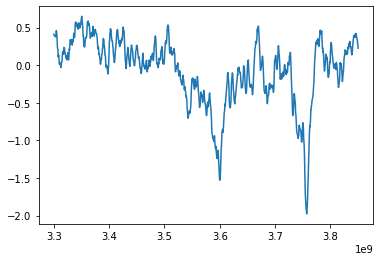

In [48]:
plt.plot(y,savgol_filter(z,15,2))

In [55]:
x,y,z=data_processing('11','11',mtype='two_tone_11q_1q_power_paper')

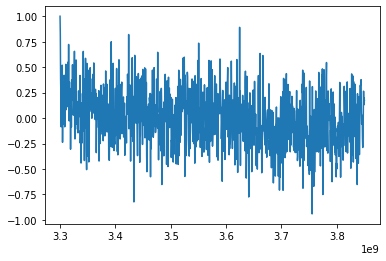

In [56]:
plt.plot(y,z)

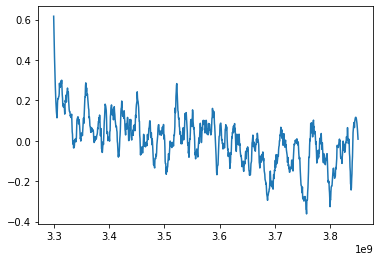

In [54]:
plt.plot(y,savgol_filter(z,25,2))

In [42]:
x,y,z=data_processing('1','10',mtype='two_tone_11q_1q_power_paper')

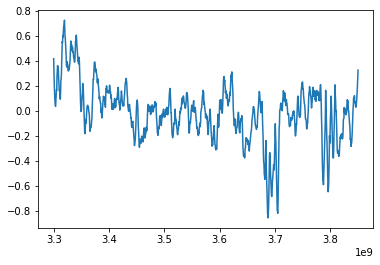

In [46]:
plt.plot(y,savgol_filter(z,15,2))

In [31]:
x,y,z=data_processing('1','11',mtype='two_tone_11q_1q_power_paper')

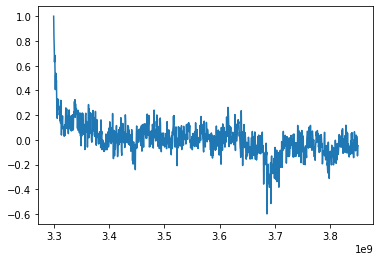

In [32]:
plt.plot(y,z)

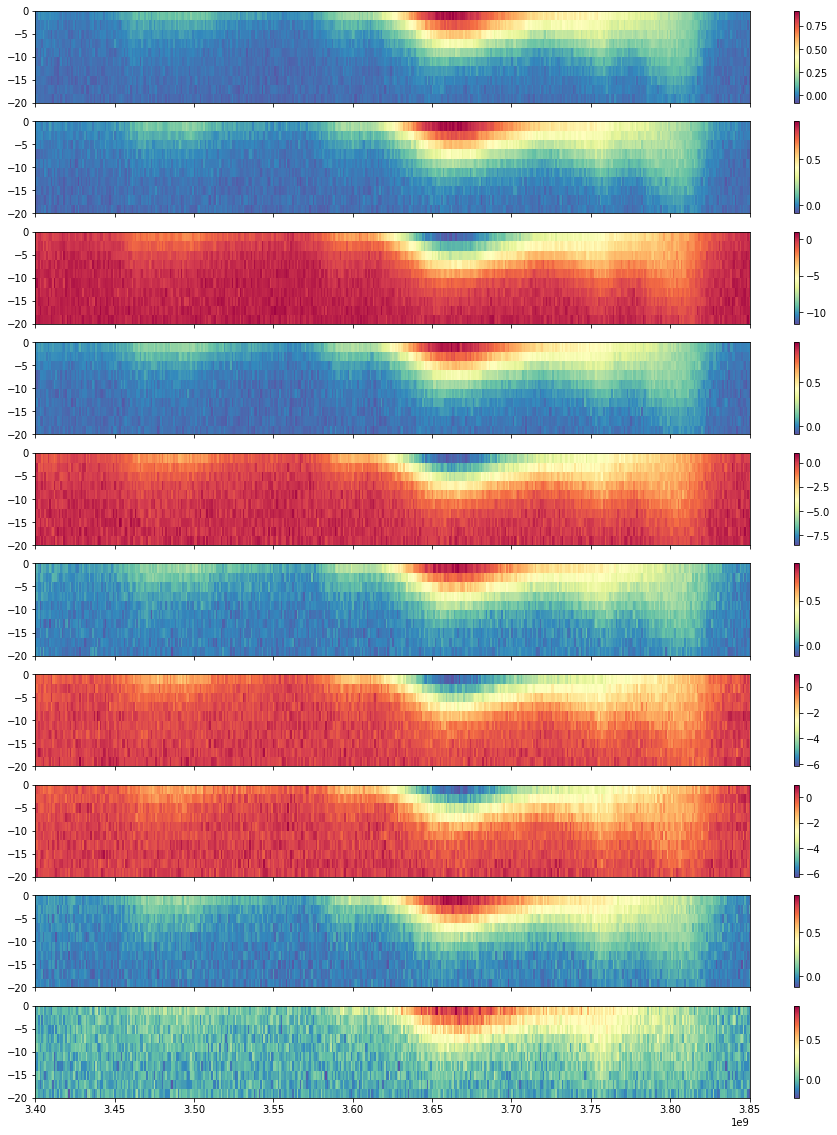

In [123]:
fig, axes = plt.subplots(10,1, figsize=(16, 20), sharex=True)
for i in range(2,12):
#     print(i+2)
    x,y,z=data_processing(str(i))
    im = axes[i-2].pcolormesh(x,y,z, cmap='Spectral_r')
    axes[i-2].set_xlim(3.4e9, 3.85e9)
    plt.colorbar(im, ax=axes[i-2])
plt.savefig('two_tone_11q_power_signal_everywhere')    
plt.show()

In [101]:
x,y,z=data_processing('11')

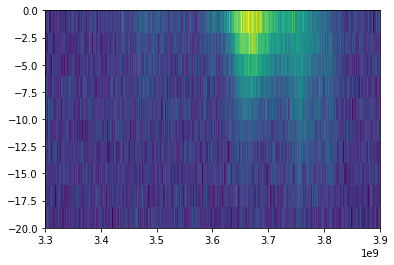

In [102]:
plt.pcolormesh(x,y,z)

(3720000000.0, 3800000000.0)

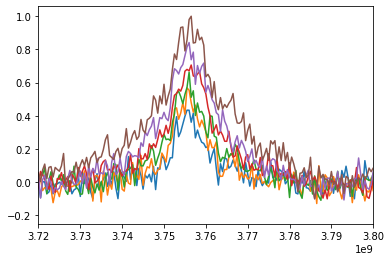

In [87]:
for i in range(len(z)):
    plt.plot(x,z[i])
plt.xlim(3.72e9,3.8e9)

In [88]:
x,y,z=data_processing('9')

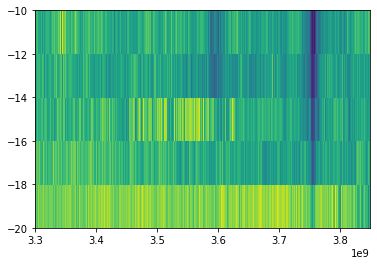

In [89]:
plt.pcolormesh(x,y,z)

(3720000000.0, 3800000000.0)

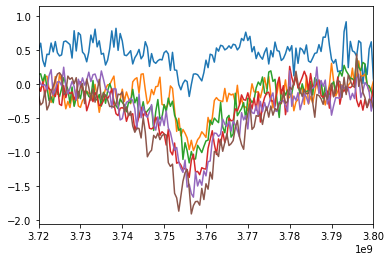

In [90]:
for i in range(len(z)):
    plt.plot(x,z[i])
plt.xlim(3.72e9,3.8e9)

In [25]:
def data_load(resonator_id,num_resonant_qubits=11,mtype='two_tone_11q_power_paper'):
    m = exdir_db_inst.select_measurement(measurement_type=mtype, 
                                                 metadata={'num_resonant_qubits': num_resonant_qubits,
                                                           'resonator_id':resonator_id})
    x = m.datasets['S-parameter'].parameters[1].values
    y = m.datasets['S-parameter'].parameters[0].values
    z_cmplx = m.datasets['S-parameter'].data_squeezed
    med = np.median(np.real(z_cmplx))+1j*np.median(np.imag(z_cmplx))
    z_nomed = z_cmplx-med

    r = np.real(z_nomed.ravel())
    i = np.imag(z_nomed.ravel())

    m = np.asarray([[np.mean(r*r), np.mean(r*i)],[np.mean(r*i), np.mean(i*i)]])
    vals, vecs = np.linalg.eigh(m)
    best_index = np.argmax(vals)
    component = vecs[best_index,:]

    z = np.abs(z_nomed*np.conj(component[0]+1j*component[1]))
    z = z/np.max(z)
    return x,y,z

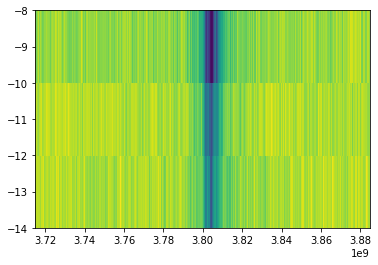

In [11]:
num_qubits=11
resonator_id=11
x,y,z=data_load(resonator_id=resonator_id, num_resonant_qubits=num_qubits, mtype='two_tone_11q_power_scan_3_8fr')

plt.pcolormesh(x,y,z)





In [40]:
x,y,z=data_load(resonator_id=10, num_resonant_qubits=11, mtype='two_tone_11q_power_scan_3_8fr')


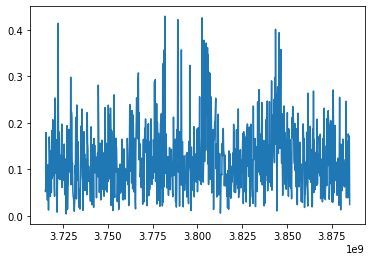

In [41]:
plt.plot(x,np.real(z[0,:]))

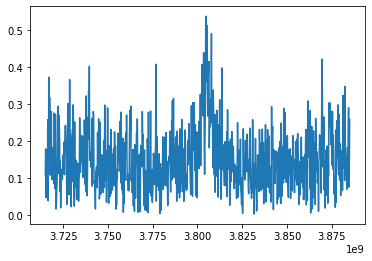

In [39]:
plt.plot(x,np.real(z[0,:]))

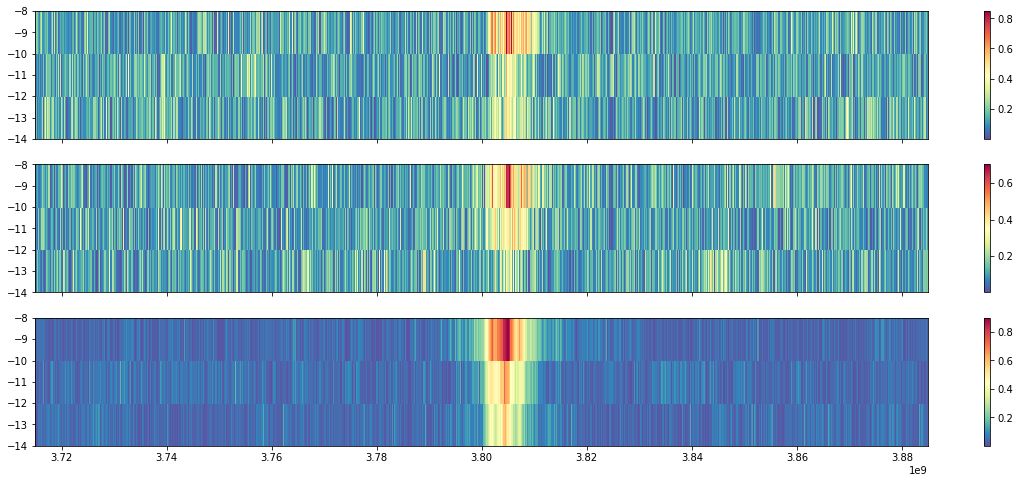

In [26]:
fig, axes = plt.subplots(3,1, figsize=(20, 8), sharex=True)
for rez_id in range(9,12):
    num_qubits=11
    x,y,z=data_load(resonator_id=rez_id, num_resonant_qubits=num_qubits, mtype='two_tone_11q_power_scan_3_8fr')
    im = axes[rez_id-9].pcolormesh(x,y,z, cmap='Spectral_r')
    axes[rez_id-9].set_xlim(x[0], x[-1])
    plt.colorbar(im, ax=axes[rez_id-9])
plt.savefig('two_tone_11q_power_signal_everywhere')    
plt.show()

In [33]:
np.asarray([1,9,10,11])[0]

1

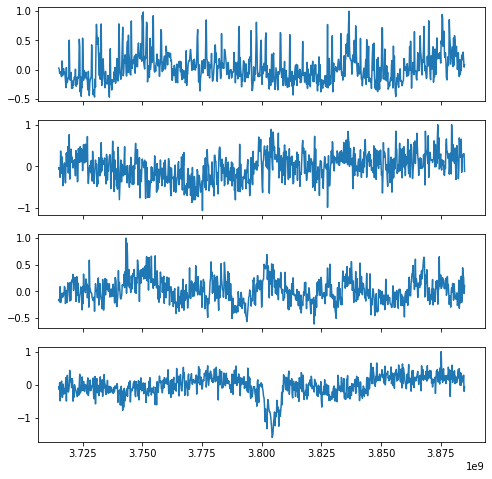

In [34]:
fig, axes = plt.subplots(4,1, figsize=(8, 8), sharex=True)
for _id,rez_id in enumerate(np.asarray([1,9,10,11])):
    num_qubits=11
    y,z=data_processing(resonator_id=rez_id, num_resonant_qubits=num_qubits, mtype='two_tone_11q_11q_power_bands_3_8fr')
    axes[_id].plot(y,z)
    
#plt.savefig('two_tone_11q_power_signal_everywhere')    
plt.show()

In [168]:
def data_ex(prep=True):
    m = exdir_db_inst.select_measurement(measurement_type='two_tone', 
                                                 metadata={'num_resonant_qubits': 1,
                                                           'resonator_id':'1',
                                                          'ex_qubit': '1'})
    x = m.datasets['S-parameter'].parameters[1].values
    y = m.datasets['S-parameter'].parameters[0].values
    if prep==True:
        z_cmplx = m.datasets['S-parameter'].data_squeezed
        med = np.median(np.real(z_cmplx))+1j*np.median(np.imag(z_cmplx))
        z_nomed = z_cmplx-med

        r = np.real(z_nomed.ravel())
        i = np.imag(z_nomed.ravel())

        m = np.asarray([[np.mean(r*r), np.mean(r*i)],[np.mean(r*i), np.mean(i*i)]])
        vals, vecs = np.linalg.eigh(m)
        best_index = np.argmax(vals)
        component = vecs[best_index,:]

        z = np.abs(z_nomed*np.conj(component[0]+1j*component[1]))
        z = z/np.max(z)
    else:
        z=m.datasets['S-parameter'].data
        med = np.median(np.real(z))+1j*np.median(np.imag(z))
        z= z-med
    return x,y/1e9, np.abs(z)

In [169]:
x,y,z=data_ex(False)

In [8]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['datetime', 'plotting']
`%matplotlib` prevents importing * from pylab and numpy



<IPython.core.display.Javascript object>


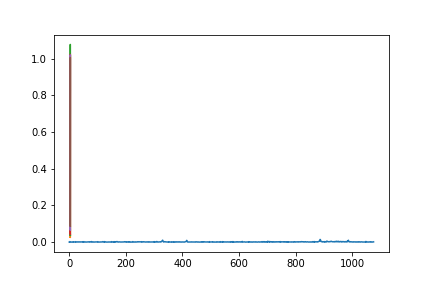

In [150]:
plot(range(len(z)),z)

In [ ]:
250:460,
840:1080   

In [100]:
z.shape

(1076,)

In [171]:
z=z.reshape((1076,))

[2.64363496e-02 3.78139745e+00 9.93882090e-01 4.94565673e-04]


<IPython.core.display.Javascript object>


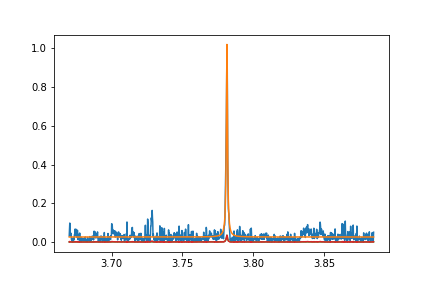

In [172]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import leastsq

def lorentzian( x, x0, a, gam ):
    return a * gam**2 / ( gam**2 + ( x - x0 )**2)

def multi_lorentz( x, params ):
    off = params[0]
    paramsRest = params[1:]
    assert not ( len( paramsRest ) % 3 )
    return off + sum( [ lorentzian( x, *paramsRest[ i : i+3 ] ) for i in range( 0, len( paramsRest ), 3 ) ] )

def res_multi_lorentz( params, xData, yData ):
    diff = [ multi_lorentz( x, params ) - y for x, y in zip( xData, yData ) ]
    return diff

xData, yData = y,z
yData = yData / max(yData)

generalWidth = 3.17136922e-04

yDataLoc = yData
startValues = [ max( yData ) ]
counter = 0

while max( yDataLoc ) - min( yDataLoc ) > .1:
    counter += 1
    if counter > 1: ### max 20 peak...emergency break to avoid infinite loop
        break
    minP = np.argmax( yDataLoc )
    minY = yData[ minP ]
    x0 = xData[ minP ]
    startValues += [ x0, minY - min( yDataLoc ), generalWidth ]
    popt, ier = leastsq( res_multi_lorentz, startValues, args=( xData, yData ) )
    yDataLoc = [ y - multi_lorentz( x, popt ) for x,y in zip( xData, yData ) ]

print(popt)
testData = [ multi_lorentz(x, popt ) for x in xData ]

fig = plt.figure()
ax = fig.add_subplot( 1, 1, 1 )
ax.plot( xData, yData )
ax.plot( xData, testData )
plt.show()

In [20]:
%matplotlib qt5

In [30]:
plot(y[250:],z[250:])

In [131]:
a1=[2.64363648e-02, 3.78139745e+00, 9.93884150e-01, 4.94563591e-04] # last is gamma  4.94563591e-04

<IPython.core.display.Javascript object>


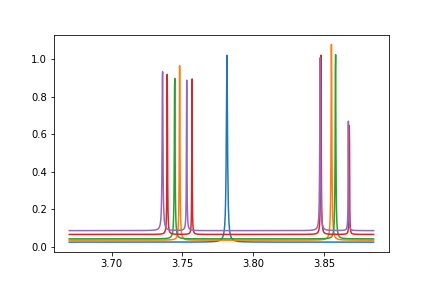

In [157]:
plt.plot(y,[multi_lorentz(x, a1) for x in y ])
plt.plot(y,[multi_lorentz(x, a2) for x in y ])
plt.plot(y,[multi_lorentz(x, a3) for x in y ])
plt.plot(y,[multi_lorentz(x, a4) for x in y ])
plt.plot(y,[multi_lorentz(x, a5) for x in y ])

<IPython.core.display.Javascript object>


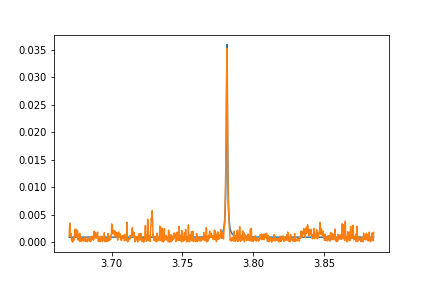

In [176]:
plt.plot(y,[multi_lorentz(x, a1) for x in y ])
plt.plot(y,z)

In [173]:
max(z)

0.03522066574244788

In [174]:
a1=[2.64363496e-02*0.03522066574244788, 3.78139745e+00, 9.93882090e-01*0.03522066574244788, 4.94565673e-04]

In [132]:
a2=[3.67442798e-02 ,3.85525167e+00, 1.06690054e+00 ,3.30212318e-04,
 3.74799165e+00, 9.28634381e-01, 2.83089821e-04]# 3.30212318e-04,2.83089821e-04

In [133]:
a3=[4.37806871e-02, 3.85811973e+00 ,1.05578427e+00 ,2.88013853e-04,
 3.74451336e+00, 9.27062933e-01, 2.95322251e-04]

In [141]:
a4=[6.73115306e-02, 3.84779356e+00, 9.54437013e-01, 2.32752155e-04,
 3.73926861e+00, 9.42069651e-01, 2.10097496e-04, 3.75673123e+00,
 1.00804055e+00, 1.46990489e-04, 3.86788733e+00, 7.72504500e-01,
 1.50993278e-04]

In [144]:
a5=[8.75302348e-02, 3.73590831e+00, 9.13636418e-01, 3.22092569e-04,
 3.75298243e+00, 8.05889416e-01,2.06965673e-04, 1.15859063e-01, 
 3.84726605e+00, 9.66238920e-01, 2.92580590e-04,
 3.86720645e+00, 5.82949777e-01,1.85730095e-04]

In [166]:
a5=[8.75302348e-02*0.010770743911496903, 3.73590831e+00, 9.13636418e-01*0.010770743911496903, 3.22092569e-04,
 3.75298243e+00, 8.05889416e-01*0.010770743911496903, 2.06965673e-04, 3.84726605e+00, 9.66238920e-01*0.014516710076938166, 2.92580590e-04,
 3.86720645e+00, 5.82949777e-01*0.014516710076938166, 1.85730095e-04]

In [ ]:
250:460, for 5qubits
840:1080 